# 2일차 2교시 NDVI 및 LST 이미지 제작(실습)

In [32]:
# 라이브러리 불러오기

import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import mapping

In [33]:
os.getcwd()

'D:\\00_Landsat in python\\1일차\\data\\2013-2023'

In [35]:
RED2013 = rio.open("2013/LC08_L1TP_114035_20130817_20200912_02_T1_B4.TIF") #[RED] 2013 폴더 안 4번째 Band(B4).TIF directory 작성
NIR2013 = rio.open("2013/LC08_L1TP_114035_20130817_20200912_02_T1_B5.TIF") #[NIR] 2013 폴더 안 5번째 Band(B5).TIF directory 작성
RED2023 = rio.open("2023/LC09_L1TP_114035_20230805_20230805_02_T1_B4.TIF") #[RED] 2023 폴더 안 4번째 Band(B4).TIF directory 작성
NIR2023 = rio.open("2023/LC09_L1TP_114035_20230805_20230805_02_T1_B5.TIF") #[NIR] 2023 폴더 안 5번째 Band(B5).TIF directory 작성

In [36]:
# 메타데이터 복사
output_meta_2013 = RED2013.meta.copy()
output_meta_2023 = RED2023.meta.copy()

In [38]:
output_meta_2013

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 7681,
 'height': 7821,
 'count': 1,
 'crs': CRS.from_epsg(32652),
 'transform': Affine(30.0, 0.0, 412485.0,
        0.0, -30.0, 4105515.0)}

In [37]:
RED2013 = RED2013.read(1).astype('float32')
NIR2013 = NIR2013.read(1).astype('float32')
RED2023 = RED2023.read(1).astype('float32')
NIR2023 = NIR2023.read(1).astype('float32')

In [39]:
NDVI2013 = np.where((NIR2013+RED2013)==0, 0, (NIR2013-RED2013)/(NIR2013+RED2013))
NDVI2013

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
NDVI2023 = np.where((NIR2023+RED2023)==0, 0, (NIR2023-RED2023)/(NIR2023+RED2023))
NDVI2023

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
NDVI2013.shape

(7821, 7681)

In [44]:
# 메타데이터 업데이트
output_meta_2013.update({
    'driver': 'GTiff',
    'height': NDVI2013.shape[0],
    'width': NDVI2013.shape[1],
    'count': 1,
    'dtype': 'float32'
})

output_meta_2023.update({
    'driver': 'GTiff',
    'height': NDVI2023.shape[0],
    'width': NDVI2023.shape[1],
    'count': 1,
    'dtype': 'float32'
})

# NDVI 값을 새로운 래스터 파일로 저장
with rio.open('NDVI2013.tif', 'w', **output_meta_2013) as dst:
    dst.write(NDVI2013, 1)

with rio.open('NDVI2023.tif', 'w', **output_meta_2023) as dst:
    dst.write(NDVI2023, 1)

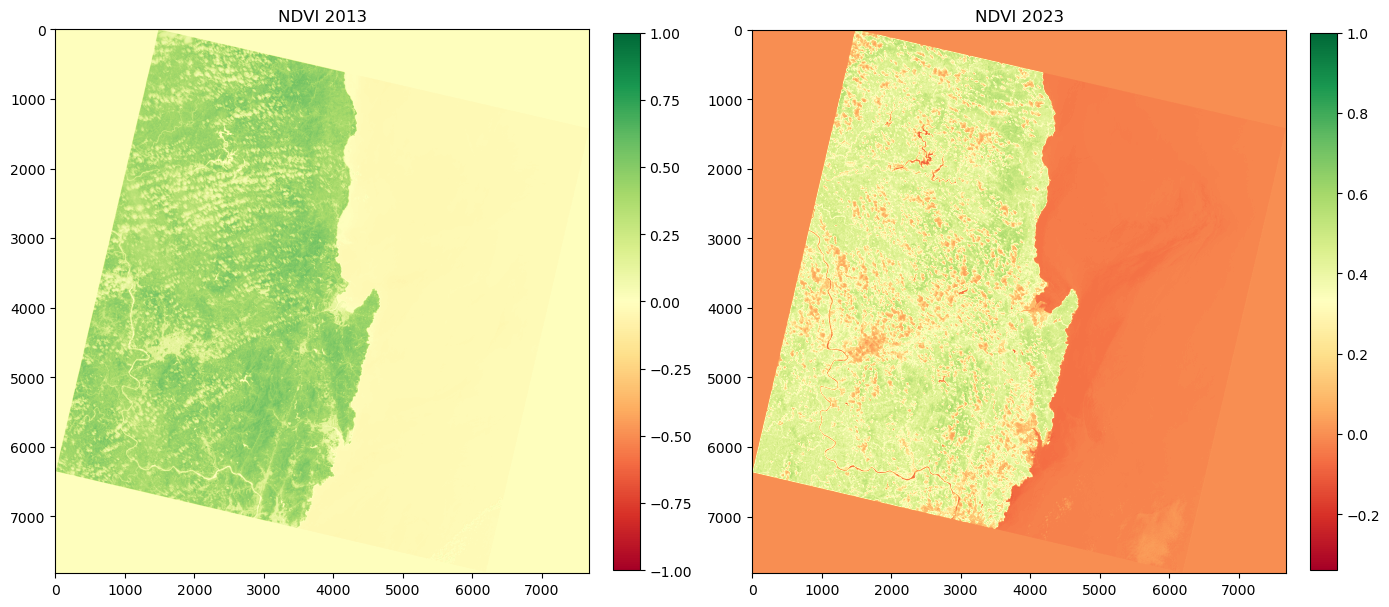

In [45]:
# NDVI 플롯
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# 2013년 NDVI 플롯
ax1.set_title('NDVI 2013')
ndvi_plot1 = ax1.imshow(NDVI2013, cmap='RdYlGn')
fig.colorbar(ndvi_plot1, ax=ax1, fraction=0.046, pad=0.04)

# 2023년 NDVI 플롯
ax2.set_title('NDVI 2023')
ndvi_plot2 = ax2.imshow(NDVI2023, cmap='RdYlGn')
fig.colorbar(ndvi_plot2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [48]:
os.getcwd()

'D:\\00_Landsat in python\\1일차\\data\\2013-2023'

In [49]:
# Open up boundary extent using GeoPandas
Daegu_boundary_path = "D:/00_Landsat in python/1일차/data/Daegu/Daegu.shp" # Daegu.shp가 있는 directory 작성
Daegu_boundary = gpd.read_file(Daegu_boundary_path)

In [50]:
# 좌표계(CRS) 확인
# Get the CRS of your data
landsat_crs = es.crs_check(all_landsat_bands[0])

print("Landsat crs is:", landsat_crs)
print("Fire boundary crs", Daegu_boundary.crs)

Landsat crs is: EPSG:32652
Fire boundary crs EPSG:5181


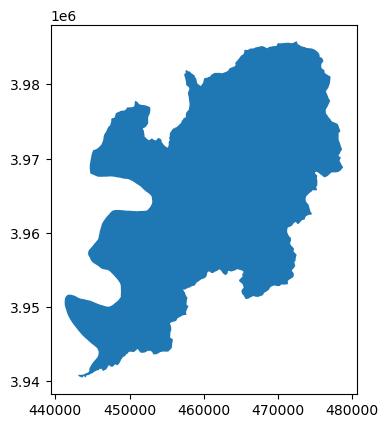

In [51]:
# 쉐이프 보기
# Reproject data to CRS of raster data
Daegu_boundary_utmz52 = Daegu_boundary.to_crs(landsat_crs)
Daegu_boundary_utmz52.plot()
plt.show()

In [52]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from matplotlib import pyplot as plt

In [55]:
# NDVI 파일 경로
ndvi_2013 = 'D:/00_Landsat in python/1일차/data/2013-2023/NDVI2013.tif' # NDVI2013.TIF 경로 입력
ndvi_2023 = 'D:/00_Landsat in python/1일차/data/2013-2023/NDVI2023.tif' # NDVI2013.TIF 경로 입력

In [59]:
os.getcwd()

'D:\\00_Landsat in python\\1일차\\data\\2013-2023'

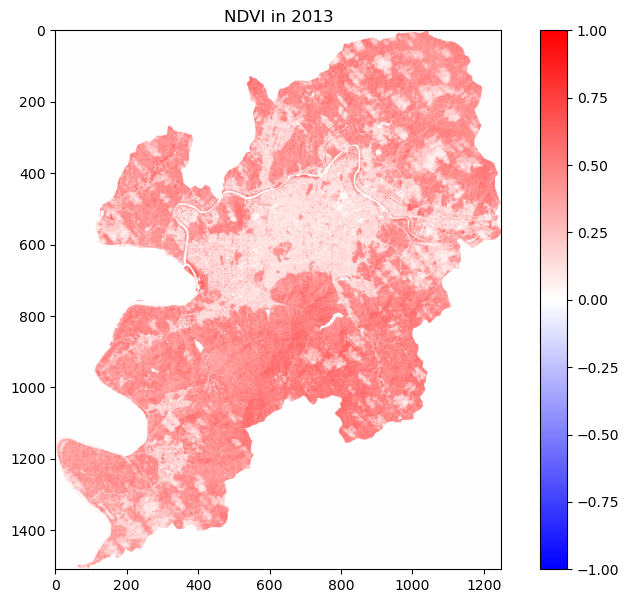

In [77]:
# 2013년 NDVI image (clipped)

# shape 파일 읽기
clip_bound = Daegu_boundary_utmz52

# NDVI 파일 열기
with rasterio.open(ndvi_2013) as src:
    # shape 파일과 NDVI 래스터를 클립
    clipped_ndvi_13, clipped_transform = mask(src, clip_bound.geometry, crop=True)
    clipped_meta = src.meta.copy()

# 클립된 NDVI 래스터 플롯
plt.figure(figsize=(10, 7))
plt.imshow(clipped_ndvi_13[0], cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDVI in 2013')
plt.show()

# 클립된 NDVI 래스터 저장
clipped_meta.update({
    'height': clipped_ndvi_13.shape[1],
    'width': clipped_ndvi_13.shape[2],
    'transform': clipped_transform
})

output_file = 'NDVI2013_clipped.tif'
with rasterio.open(output_file, 'w', **clipped_meta) as dst:
    dst.write(clipped_ndvi_13)

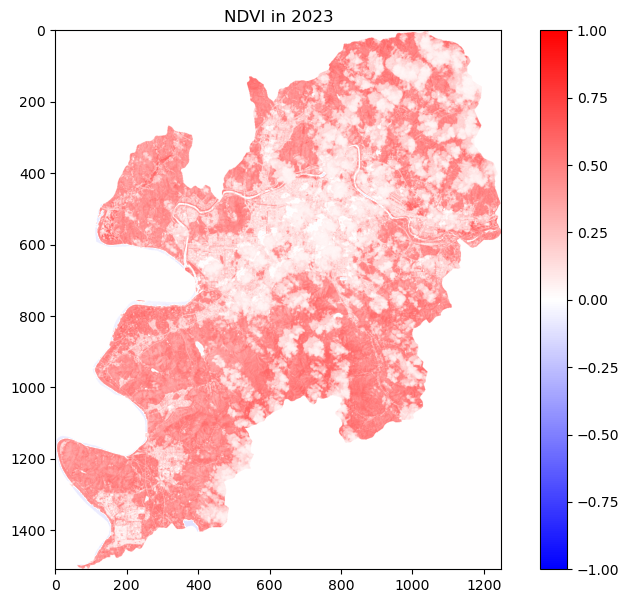

In [78]:
# 2023년 NDVI image (clipped)

# shape 파일 읽기
clip_bound = Daegu_boundary_utmz52

# NDVI 파일 열기
with rasterio.open(ndvi_2023) as src:
    # shape 파일과 NDVI 래스터를 클립
    clipped_ndvi_23, clipped_transform = mask(src, clip_bound.geometry, crop=True)
    clipped_meta = src.meta.copy()

# 클립된 NDVI 래스터 플롯
plt.figure(figsize=(10, 7))
plt.imshow(clipped_ndvi_23[0], cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDVI in 2023')
plt.show()

# 클립된 NDVI 래스터 저장
clipped_meta.update({
    'height': clipped_ndvi_23.shape[1],
    'width': clipped_ndvi_23.shape[2],
    'transform': clipped_transform
})

output_file = 'NDVI2023_clipped.tif'
with rasterio.open(output_file, 'w', **clipped_meta) as dst:
    dst.write(clipped_ndvi_23)

In [73]:
# 클립된 NDVI 파일 경로

NDVI2013_file = 'D:/00_Landsat in python/1일차/data/2013-2023/NDVI2013_clipped.tif'
NDVI2023_file = 'D:/00_Landsat in python/1일차/data/2013-2023/NDVI2023_clipped.tif'

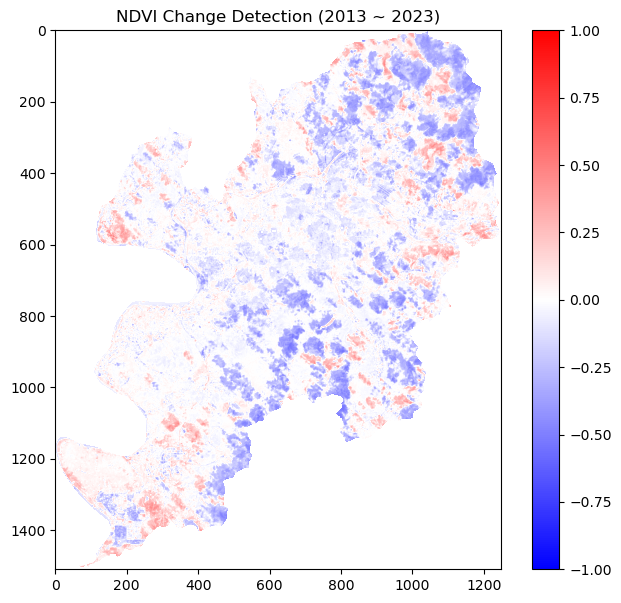

In [84]:
# NDVI 파일 열기 (데이터를 읽어와야 함)
with rasterio.open(NDVI2013_file) as src2013:
    NDVI2013 = src2013.read(1, masked=True)

with rasterio.open(NDVI2023_file) as src2023:
    NDVI2023 = src2023.read(1, masked=True)

# NDVI 변화 검출
NDVI_changed = NDVI2023 - NDVI2013

# NDVI 변화 검출 결과 플롯
plt.figure(figsize=(10, 7))
plt.title('NDVI Change Detection (2013 ~ 2023)')
ndvi_change_plot = plt.imshow(NDVI_changed, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(ndvi_change_plot, fraction=0.046, pad=0.04)
plt.show()

In [87]:
NDVI2013Meta = NDVI2013.meta.copy()

AttributeError: 'MaskedArray' object has no attribute 'meta'

In [88]:
# NDVI_changed 이미지를 tif로 저장

NDVI2013M = rasterio.open("D:/00_Landsat in python/1일차/data/2013-2023/NDVI2013_clipped.tif") # 여기에 raster file 가지고오시면 됩니다

NDVI2013Meta = NDVI2013M.meta.copy()

NDVI2013Meta.update({
    'height': NDVI2013M.height,
    'width': NDVI2013M.width,
    'transform': NDVI2013M.transform
})

with rasterio.open('NDVI_changed.tif', 'w', **NDVI2013Meta) as dst:
    dst.write(NDVI_changed, 1)

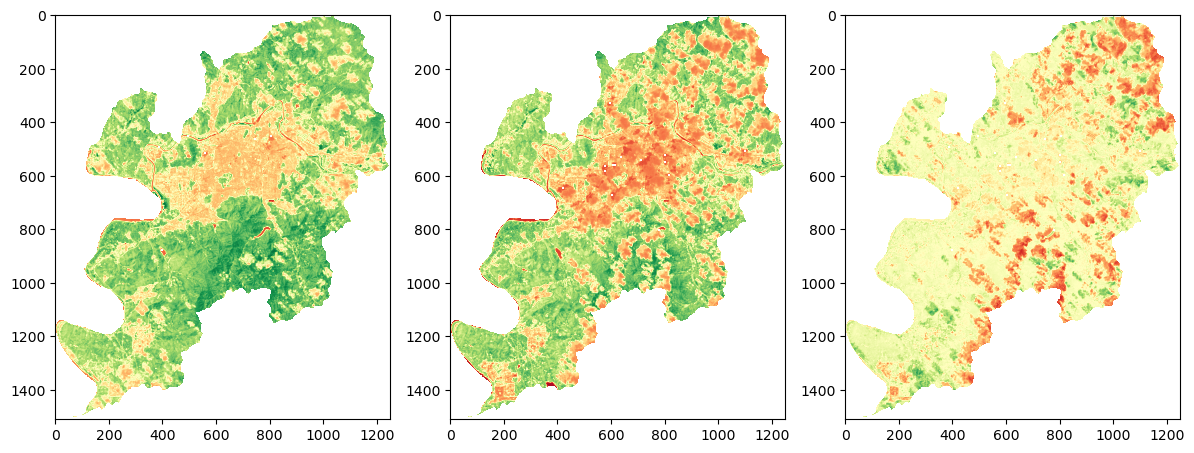

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(NDVI2013,  cmap="RdYlGn") #2013
ax[1].imshow(NDVI2023,  cmap="RdYlGn") #2023
ax[2].imshow(NDVI_changed,  cmap="RdYlGn") #changes

# plt.savefig('final_image.png')

fig.tight_layout()